In [1]:
import re
import pandas as pd
import numpy as np
from numpy.lib.function_base import vectorize
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("sentiment_analysis.csv")
df.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [ ]:
size = df.shape
print(f"Rows: {size[0]}, columns = {size[1]}")


Rows: 550391, columns = 3


## Helper Functions

In [ ]:
# Remove punctuations
def remove_punc(s):
    return s.translate(str.maketrans('', '', string.punctuation))

# removes same successive alphabets from words
def remove_repeating_char(text):
    return re.sub(r'(.)\1{1,}', r'\1', text)

# read the file containing stop words and converts it to list
def get_stop_words_from_txt(fname):
    stop_words = []
    with open(fname, 'r', encoding='utf-8') as f:
        for wrd in f.read().splitlines():
            stop_words.append(remove_repeating_char(wrd))
    return stop_words

# removes stop words from text
def clean_stop_words(text, stop_words):
    return " ".join([word for word in str(text).split() if word not in stop_words])



## Cleaning Data Function

In [ ]:
def clean_data(df_data, add_stop_words= []):
    '''
    #TODO Documentation 
    '''
    # Convert text to lower case
    df_data = df_data.str.lower()

    # remove complete urls from the text column
    df_data = df_data.str.replace('https\S+|www.\S+', '', case=False, regex=True)

    # remove all numbers from the text column
    df_data = df_data.str.replace('\d+', '', regex=True)

    # Remove punctuations
    df_data = df_data.apply(lambda x: remove_punc(x))

    # remove succesie repeating characters
    df_data = df_data.apply(lambda x: remove_repeating_char(x))

    # read min_stop_words.txt file and add every word to a list
    minimal_stop_words = get_stop_words_from_txt('minimal_stop_words.txt')

    # if any extra stop words are given add them to minimal_stop_words list
    minimal_stop_words.extend(add_stop_words)

    # remove minimal stop words from text
    df['text'] = df['text'].apply(lambda text: clean_stop_words(text, minimal_stop_words))

    return df_data


In [ ]:
# call the function to clean the data
df['text'] = clean_data(df['text'])
df.head()

,ID,text,label
0,7.680980e+17,josh jenkins is loking forward to tab breders ...,1
1,7.680980e+17,rt mianusmanjaved congratulations pakistan on ...,1
2,7.680980e+17,rt pepalerts this september yesmag is taking y...,1
3,7.680980e+17,rt davidgaibis newly painted wals thanks a mil...,1
4,7.680980e+17,rt cedricfeschote excited to anounce as of jul...,1


In [ ]:
for i in range(5):
    print(df.head()['text'][i])

josh jenkins is loking forward to tab breders crown super sunday 
rt mianusmanjaved congratulations pakistan on becoming notesteam in the world against al ods jipakzindabadralies 
rt pepalerts this september yesmag is taking you to maine mendoza’s surprise thanksgiving party she threw for her fans 
rt davidgaibis newly painted wals thanks a milion to our custodial painters this sumer great job ladiesecproud 
rt cedricfeschote excited to anounce as of july feschote lab wil be relocating to cornel mbg 


## Word Cloud visualization

In [ ]:
def word_cloud(df,label):
    '''
    # TODO documentation
    '''
    df_label = df[df['label'] == label]
    plt.figure(figsize=(10, 5))
    wc = WordCloud(max_words=1000, width=1600, height=800).generate(" ".join(df_label['text']))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

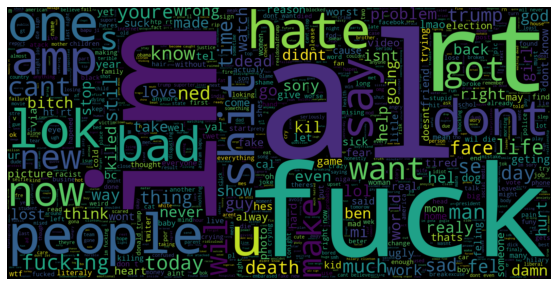

In [ ]:
word_cloud(df,0)

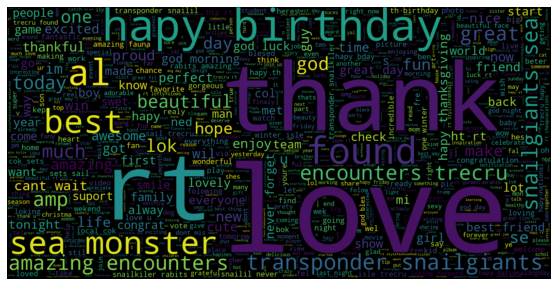

In [ ]:
word_cloud(df,1)

## Import required modules for SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# optimizing SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
def SVM(df_text,df_label, lemmatization = True, stemming = True, max_features= None):
    '''
    step 1: stemming
    step 2: lemmatization
    step 3: TFIDF Vectorization
    step 4: test train split
    step 5: building the SVM model for training and testing
    '''
    print('stemming')
    # stemming
    if stemming:
        st = nltk.PorterStemmer()
        df_text = df_text.apply(lambda text : " ".join([st.stem(word) for word in text.split()]))
    print('lemmatizer')
    # Lemmatizer 
    if lemmatization:
        lm = nltk.WordNetLemmatizer()
        df_text = df_text.apply(lambda text : " ".join([lm.lemmatize(word) for word in text.split()]))

    # vectorizing
    print('vectorizing')
    vectorizer = TfidfVectorizer(max_features = max_features)
    X = df_text
    y = df_label
    
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)
    vectorizer.fit(df_text)
    Xv_train=vectorizer.transform(X_train)
    Xv_test=vectorizer.transform(X_test)
    
    print('optimizing')
    # optmize
    c = [0.01, 0.1, 1, 10, 100]
    kernel = ['linear','rbf','sigmoid']
    g = ['scale', 'auto']

    search_space = {'C': c, 'kernel': kernel, 'gamma':g}
    base_model = SVC()
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)
    search = GridSearchCV(estimator= base_model, scoring= 'accuracy', param_grid = search_space)
    
    results = search.fit(Xv_train, y_train)
    
    return {"best score": results.best_score_, 'best parameter':results.best_params_}

In [ ]:
print(SVM(df['text'][:5000],df['label'][:5000], max_features=20000))

In [ ]:
def SVM(df_text,df_label, lemmatization = True, stemming = True, max_features= None):
    '''
    step 1: stemming
    step 2: lemmatization
    step 3: TFIDF Vectorization
    step 4: test train split
    step 5: building the SVM model for training and testing
    '''
    # stemming
    if stemming:
        st = nltk.PorterStemmer()
        df_text = df_text.apply(lambda text : " ".join([st.stem(word) for word in text.split()]))

    # Lemmatizer 
    if lemmatization:
        lm = nltk.WordNetLemmatizer()
        df_text = df_text.apply(lambda text : " ".join([lm.lemmatize(word) for word in text.split()]))

    # vectorizing
    vectorizer = TfidfVectorizer(max_features = max_features)
    X = df_text
    y = df_label

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)
    vectorizer.fit(df_text)
    Xv_train=vectorizer.transform(X_train)
    Xv_test=vectorizer.transform(X_test)

    # build build and measure accuracy
    model2=SVC(C= 10, gamma= 'scale', kernel = 'sigmoid')
    model2.fit(Xv_train,y_train)
    y_pred=model2.predict(Xv_test)
    return accuracy_score(y_test, y_pred)

In [ ]:
print(SVM(df['text'],df['label'], max_features=20000))

# KNN

In [ ]:
def KNN(df_text,df_label, lemmatization = True, stemming = True, max_features= None):
    '''
    step 1: stemming
    step 2: lemmatization
    step 3: TFIDF Vectorization
    step 4: test train split
    step 5: building the KNN model for training and testing
    '''
    # stemming
    if stemming:
        st = nltk.PorterStemmer()
        df_text = df_text.apply(lambda text : " ".join([st.stem(word) for word in text.split()]))

    # Lemmatizer 
    if lemmatization:
        lm = nltk.WordNetLemmatizer()
        df_text = df_text.apply(lambda text : " ".join([lm.lemmatize(word) for word in text.split()]))

    # vectorizing
    vectorizer = TfidfVectorizer(max_features = max_features)
    X = df_text
    y = df_label

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)
    vectorizer.fit(df_text)
    Xv_train=vectorizer.transform(X_train)
    Xv_test=vectorizer.transform(X_test)

    # build build and measure accuracy
    model3=KNeighborsClassifier(n_neighbors= 9, metric= 'minkowski', p = 2)
    model3.fit(Xv_train,y_train)
    y_pred=model3.predict(Xv_test)
    return accuracy_score(y_test, y_pred)

In [ ]:
print(KNN(df['text'],df['label'], max_features=20000))

In [ ]:
def D_Tree(df_text,df_label, lemmatization = True, stemming = True, max_features= None):
    '''
    step 1: stemming
    step 2: lemmatization
    step 3: TFIDF Vectorization
    step 4: test train split
    step 5: building the Decision tree model for training and testing
    '''
    # stemming
    if stemming:
    st = nltk.PorterStemmer()
    df_text = df_text.apply(lambda text : " ".join([st.stem(word) for word in text.split()]))

    # Lemmatizer 
    if lemmatization:
    lm = nltk.WordNetLemmatizer()
    df_text = df_text.apply(lambda text : " ".join([lm.lemmatize(word) for word in text.split()]))

    # vectorizing
    vectorizer = TfidfVectorizer(max_features = max_features)
    X = df_text
    y = df_label

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)
    vectorizer.fit(df_text)
    Xv_train=vectorizer.transform(X_train)
    Xv_test=vectorizer.transform(X_test)

    # build build and measure accuracy
    model4=DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3, min_samples_split=3)
    model4.fit(Xv_train,y_train)
    y_pred=model4.predict(Xv_test)
    return accuracy_score(y_test, y_pred)

In [ ]:
print(D_Tree(df['text'],df['label'], max_features=20000))

# part 2

For the prediction purpose I use the data sent on my own from the Internet that is given at the following link
https://www.kaggle.com/datasets/bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows

This data set is not labeled so after the prediction, we cannot measure how accurately our model worked on the this Data

In [2]:
df1 = pd.read_csv("0819_UkraineCombinedTweetsDeduped.csv")
df1 = df1[["text"]]
df1.head()

In [ ]:
# call the function to clean the data
df1['text'] = clean_data(df1['text'])
df1.head()

In [ ]:
# removing the \n from the text
for i in range(len(df1['text'])):
    df1['text'][i] = df1['text'][i].replace('\n', ' ').replace('  ', ' ')

# prediction using the best model

In [ ]:
def logistic_regression_test(df_text, vectorizer, model1, lemmatization = True, stemming = True, max_features= None):
    '''
    step 1: stemming
    step 2: lemmatization
    step 3: TFIDF Vectorization using previous object
    step 4: predicting using the best model (logistic regression)
    '''
    # stemming
    if stemming:
        st = nltk.PorterStemmer()
        df_text = df_text.apply(lambda text : " ".join([st.stem(word) for word in text.split()]))

    # Lemmatizer 
    if lemmatization:
        lm = nltk.WordNetLemmatizer()
        df_text = df_text.apply(lambda text : " ".join([lm.lemmatize(word) for word in text.split()]))

    X = df_text

    Xv=vectorizer.transform(X)

    # build build and measure accuracy
    y_pred=model1.predict(Xv)
    return y_pred

In [ ]:
predicted_labels = logistic_regression_test(df_text = df1['text'],vectorizer=vecto,model1=model ,max_features=20000)

In [ ]:
predicted_labels

In [ ]:
for i, j in zip(range(5), predicted_labels[:5]):
    print(df1.head()['text'][i], j)
    print('**********************')

In [ ]:
for i, j in zip(range(len(df1)-5, len(df1)), predicted_labels[-5:]):
    print(df1.tail()['text'][i], j)
    print('**********************')

# Observation and Discussion

By looking into the actual data and They are pretty good labels. It seems that the model has done quite a good job. Since the label was not available in this data, so we could not calculate that accuracy or other measurement metrics.

we had to do the manual inspection of the model. that is why I have printed few cleaned text and their predicted labels by the model.

looking into these head and tails of the data (top and bottom five instances of the data) We can clearly understand that the model has performed really well.